## Visualizing wind nudging windows
##### Created by Ash Gilbert
##### Last updated November 17, 2023
###### Email Ash (ash.gilbert@colorado.edu) with any questions, ideas, or comments

#### Import libraries

In [1]:
# Numpy
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmcrameri import cm

# Ignore warnings
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings('ignore')

#### Set constants, parameters, and arrays
The number of levels, latitude bands, and longitude bands may vary depending on your model resolution. The values given are for a 1° horizontal model resolution and a standard 32 vertical level resolution in CESM2.

The parameters are the same ones that would determine the size of a nudging window in the nudging namelist for CESM2. For definitions of the parameters and documentation on nudging, see https://ncar.github.io/CAM/doc/build/html/users_guide/physics-modifications-via-the-namelist.html#nudging. 

In [2]:
# Constants
nlev = 32
nlat = 180
nlon = 360

# Parameters
hwin_invert = False
hwin_lo = 1. if hwin_invert else 0.
hwin_hi = 0. if hwin_invert else 1.
vwin_invert = False
vwin_lo = 1. if vwin_invert else 0.
vwin_hi = 0. if vwin_invert else 1.
hwin_lat0 = 45.
hwin_latw = 90.
hwin_latdel = 3.
hwin_lon0 = 180.
hwin_lonw = 999.
hwin_londel = 1.
vwin_hindex = 24.
vwin_hdel = 0.1
vwin_lindex = 0.
vwin_ldel = 0.1

# Create arrays
lon_arr = np.linspace(0.,(nlon*360/(nlon+1)),nlon)
lat_arr = np.linspace(-90,90,nlat)
lev_arr = np.linspace(1,nlev,nlev)

#### Set up horizontal window

In [3]:
# Create lat/lon profiles for window
# Longitude
lonx = (lon_arr-hwin_lon0)
lonx = np.where(lonx <= -180,lonx+360,lonx)
lonx = np.where(lonx > 180, lonx-360, lonx)
lon0_min = -(hwin_lonw/2.) 
lon0_max =  (hwin_lonw/2.) 
lon_lo   = (lonx - lon0_min)/hwin_londel
lon_hi   = (lon0_max - lonx)/hwin_londel

# Latitude
lat0_min = hwin_lat0 - (hwin_latw/2.) 
lat0_max = hwin_lat0 + (hwin_latw/2.) 
lat_lo   = (lat_arr - lat0_min)/hwin_latdel
lat_hi   = (lat0_max - lat_arr)/hwin_latdel

# Calc min/max  of RAW window function
Val1_p=((1.+np.tanh(( 180. - lon0_min)/hwin_londel))/2.)
Val1_0=((1.+np.tanh((   0. - lon0_min)/hwin_londel))/2.)
Val1_n=((1.+np.tanh((-179. - lon0_min)/hwin_londel))/2.)
Val2_p=((1.+np.tanh((lon0_max - 180. )/hwin_londel))/2.)
Val2_0=((1.+np.tanh((lon0_max -   0. )/hwin_londel))/2.)
Val2_n=((1.+np.tanh((lon0_max + 179. )/hwin_londel))/2.)

Val3_p=((1.+np.tanh(( 90. - lat0_min)/hwin_latdel))/2.)
Val3_0=((1.+np.tanh((hwin_lat0 - lat0_min)/hwin_latdel))/2.)
Val3_n=((1.+np.tanh((-90. - lat0_min)/hwin_latdel))/2.)
Val4_p=((1.+np.tanh((lat0_max -  90.)/hwin_latdel))/2.)
Val4_0=((1.+np.tanh((lat0_max - hwin_lat0)/hwin_latdel))/2.)
Val4_n=((1.+np.tanh((lat0_max +  90.)/hwin_latdel))/2.)

Hmax = Val1_0*Val2_0*Val3_0*Val4_0
Htest = np.array([Val1_p*Val2_p*Val3_n*Val4_n,
            Val1_p*Val2_p*Val3_p*Val4_p,
            Val1_n*Val2_n*Val3_n*Val4_n,
            Val1_n*Val2_n*Val3_p*Val4_p])
Hmin = min(Htest)

Hcoef = np.full((nlat,nlon),0,dtype=float)

# Load RAW window function
for i in range(0,nlat):
    for j in range(0,nlon):
        Hcoef[i,j] = ((1.+np.tanh(lon_lo[j]))/2.)*((1.+np.tanh(lon_hi[j]))/2.)*((1.+np.tanh(lat_lo[i]))/2.)*((1.+np.tanh(lat_hi[i]))/2.)

# Scale window function to span values between Hlo & Hhi
if (Hmax <= Hmin):
    Hcoef[:,:] = 1.0
else:
    Hcoef = (Hcoef-Hmin)/(Hmax-Hmin)

Hcoef = hwin_lo+Hcoef*(hwin_hi-hwin_lo)

#### Set up vertical window

In [4]:
# Set level profiles for window function
lev0 = (vwin_lindex+vwin_hindex)/2
ilev = np.argmin(np.abs(lev_arr-lev0))
lev_lo = (lev_arr-vwin_lindex)/vwin_ldel
lev_hi = (vwin_hindex-lev_arr)/vwin_hdel

# Loop over lat/lon & load RAW window function
Vcoef = np.full(nlev,1,dtype=float)

for i in range(0,nlev):
    Vcoef[i] = ((1.+np.tanh(lev_lo[i]))/2.)*((1.+np.tanh(lev_hi[i]))/2.)

# Scale the window function to span values between Vlo & Vhi
Vmax = np.max(Vcoef)
Vmin = np.min(Vcoef)

if (Vmax <= Vmin):
    Vcoef[:] = 1.
else:
    Vcoef = (Vcoef-Vmin)/(Vmax-Vmin)

Vcoef = vwin_lo+Vcoef*(vwin_hi-vwin_lo)

#### Plot horizontal window

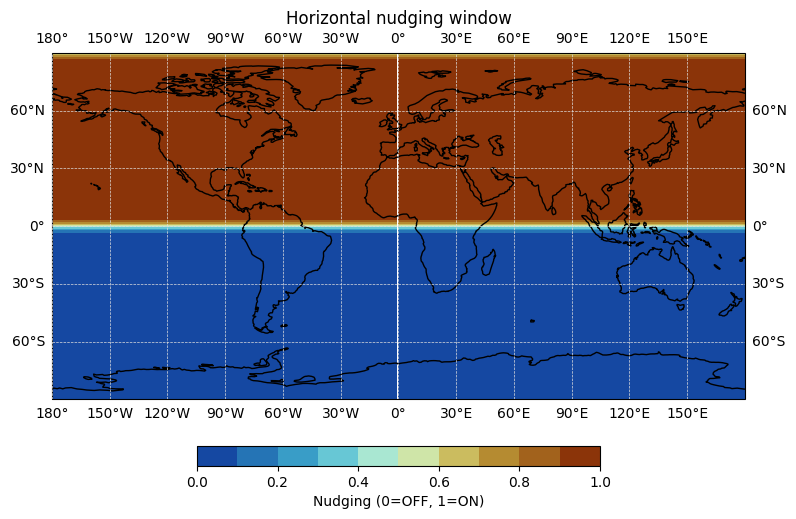

In [23]:
# Set up
fig1, ax1 = plt.subplots(1,1,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig1.set_size_inches(13,6)
LON,LAT = np.meshgrid(lon_arr,lat_arr)

# Plot
cax1 = ax1.contourf(LON,LAT,Hcoef,
                    levels=np.arange(0,1.1,0.1),cmap=cm.roma_r,
                    transform=ccrs.PlateCarree(),zorder=1)

# Formatting
ax1.coastlines(zorder=3)
ax1.set_extent([-180,180,-91,91],ccrs.PlateCarree())
ax1.gridlines(crs=ccrs.PlateCarree(),zorder=4,linewidth=0.5,
              color='#dddddd',linestyle='--',xlocs=np.arange(-180,180,30),
              ylocs=np.arange(-90,90,30),draw_labels=True)
ax1.set_title('Horizontal nudging window')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

fig1.colorbar(cax1,ax=ax1,pad=0.1,label='Nudging (0=OFF, 1=ON)',location='bottom',shrink=0.4)

#### Plot latitude profile at lon0

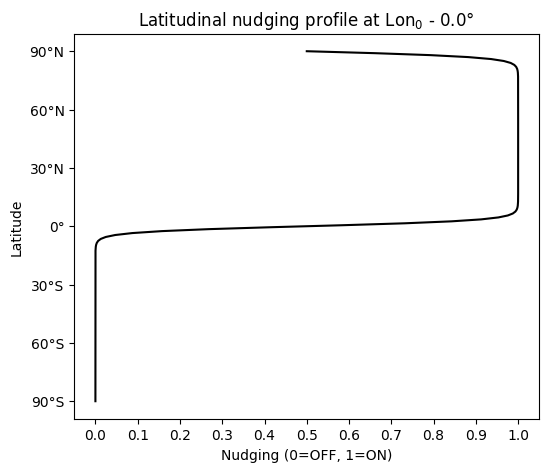

In [28]:
# Longitude selection
col = np.argmin(np.abs(lon_arr-hwin_lon0))
lon_val = hwin_lon0-180
if lon_val == 0:
    lon_str = str(lon_val)+'°'
elif lon_val < 0:
    lon_str = str(abs(lon_val))+'°W'
else:
    lon_str = str(lon_val)+'°E'

# Set up 
fig2, ax2 = plt.subplots(1,1)
fig2.set_size_inches(6,5)

# Plot
ax2.plot(Hcoef[:,col],lat_arr,'k-')

# Formatting
ax2.set_title('Latitudinal nudging profile at Lon$_0$ - '+lon_str)
ax2.set_xlabel('Nudging (0=OFF, 1=ON)')
ax2.set_xticks(np.arange(0,1.1,.1))
ax2.set_ylabel('Latitude')
ax2.set_yticks(np.arange(-90,91,30), labels=['90°S','60°S','30°S','0°','30°N','60°N','90°N'])

#### Plot longitude profile at lat0

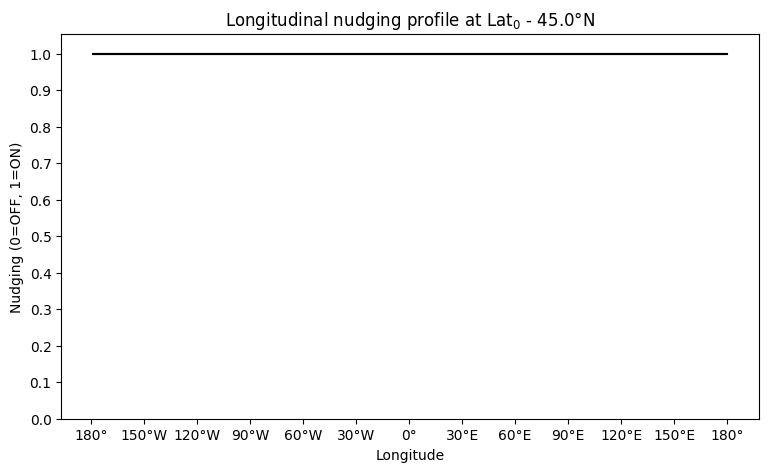

In [31]:
# Latitude selection
row = np.argmin(np.abs(lat_arr-hwin_lat0))
lat_val = hwin_lat0
if lat_val == 0:
    lat_str = str(lat_val)+'°'
elif lat_val < 0:
    lat_str = str(abs(lat_val))+'°S'
else:
    lat_str = str(lat_val)+'°N'

# Set up 
fig3, ax3 = plt.subplots(1,1)
fig3.set_size_inches(9,5)

# Plot
ax3.plot(lonx,Hcoef[row,:],'k-')

# Formatting
ax3.set_title('Longitudinal nudging profile at Lat$_0$ - '+lat_str)
ax3.set_ylabel('Nudging (0=OFF, 1=ON)')
ax3.set_yticks(np.arange(0,1.1,.1))
ax3.set_xlabel('Longitude')
ax3.set_xticks(np.arange(-180,181,30),labels=['180°','150°W','120°W','90°W','60°W','30°W','0°','30°E','60°E','90°E','120°E','150°E','180°'])

#### Plot vertical profile

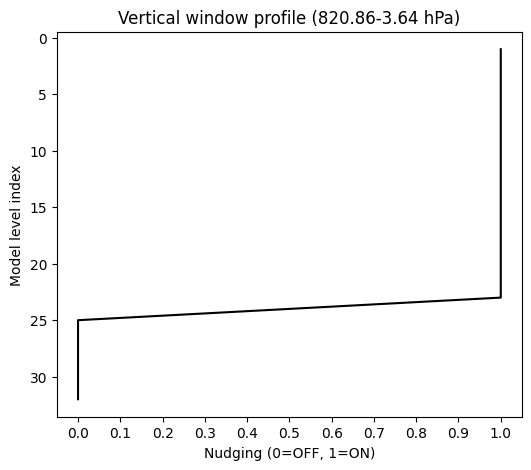

In [61]:
# Pressure level-model level index conversion
p_levels = np.array([  3.64346569,   7.59481965,  14.35663225,  24.61222   ,
        35.92325002,  43.19375008,  51.67749897,  61.52049825,
        73.75095785,  87.82123029, 103.31712663, 121.54724076,
       142.99403876, 168.22507977, 197.9080867 , 232.82861896,
       273.91081676, 322.24190235, 379.10090387, 445.9925741 ,
       524.68717471, 609.77869481, 691.38943031, 763.40448111,
       820.85836865, 859.53476653, 887.02024892, 912.64454694,
       936.19839847, 957.48547954, 976.32540739, 992.55609512])

# Set up 
fig4, ax4 = plt.subplots(1,1)
fig4.set_size_inches(6,5)

# Plot
ax4.plot(Vcoef,lev_arr,'k-')

# Formatting
ax4.set_title('Vertical window profile ({:.2f}-{:.2f} hPa)'.format(p_levels[int(vwin_hindex)],p_levels[int(vwin_lindex)]))
ax4.set_xlabel('Nudging (0=OFF, 1=ON)')
ax4.set_xticks(np.arange(0,1.1,.1))
ax4.set_ylabel('Model level index')
ax4.invert_yaxis()